In [84]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [86]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [87]:
device

device(type='cpu')

In [88]:
ticker = 'AAPL'
df = yf.download(ticker,'2020-01-01')

C:\Users\himan\AppData\Local\Temp\ipykernel_17912\1266454546.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [89]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400
2020-01-03,71.914825,72.676454,71.689965,71.847125,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146927,72.753808,71.926900,72.497514,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200
...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600


<Axes: xlabel='Date'>

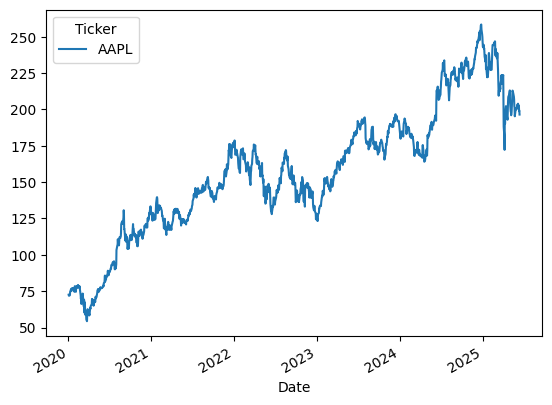

In [90]:
df.Close.plot()

In [91]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [92]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.909413
2020-01-03,-1.925323
2020-01-06,-1.912410
2020-01-07,-1.920092
2020-01-08,-1.893939
...,...
2025-06-09,0.993661
2025-06-10,1.021153
2025-06-11,0.933495


In [93]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)



In [94]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size,:-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:,:-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)

In [95]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel,self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn,cn) = self.lstm(x,(h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out

In [96]:
model = PredictionModel(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [97]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [98]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    if i % 25 == 0:
        print(i,loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.7785720229148865
25 0.016385676339268684
50 0.006880608852952719
75 0.005865749903023243
100 0.005334046203643084
125 0.004936621990054846
150 0.004609458614140749
175 0.004298830404877663


In [99]:
model.eval()

y_test_pred = model(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [100]:
train_rmse = root_mean_squared_error(y_train[:,0],y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0],y_test_pred[:,0])

In [101]:
train_rmse

np.float32(2.804352)

In [102]:
test_rmse

np.float32(9.125748)

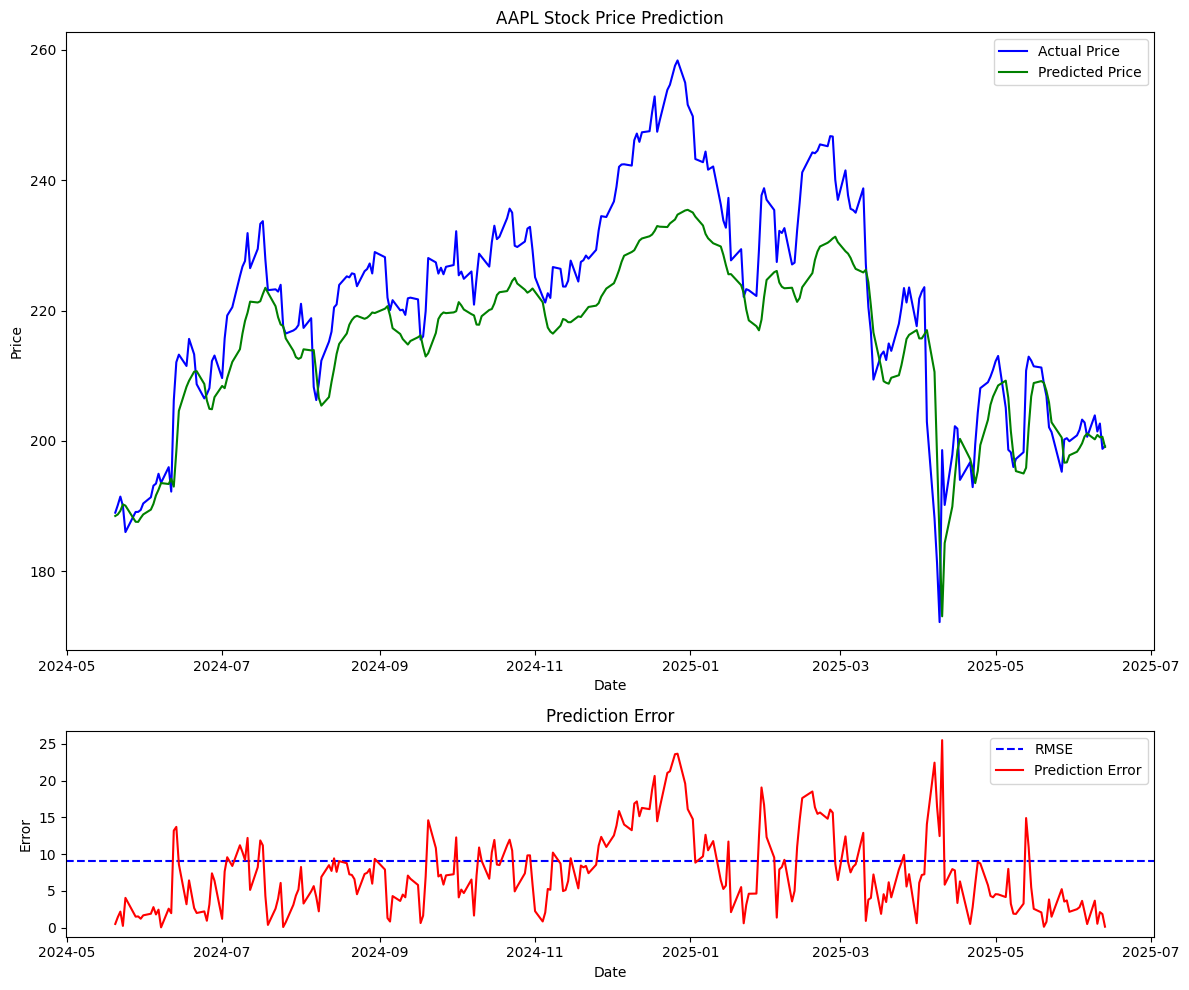

In [111]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot actual vs predicted prices
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')
ax1.legend()
ax1.set_title(f"{ticker} Stock Price Prediction")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot prediction error
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
ax2.set_title('Prediction Error')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error')

plt.tight_layout()
plt.show()
